In [2]:
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import ds_charts as ds
import lime.lime_tabular
import matplotlib.pyplot as plt
from seaborn import distplot,heatmap
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler,  KBinsDiscretizer

In [3]:
#Definição variáveis iniciais
file = './Csvs/XAI - Limpo_dummified_minmax_smote.csv'
name = 'XAI - Limpo_dummified_minmax_smote'
tc = 'surgycal margin'
data = pd.read_csv(file,index_col=tc,na_values='',sep=',', decimal='.')
df = pd.DataFrame(data)

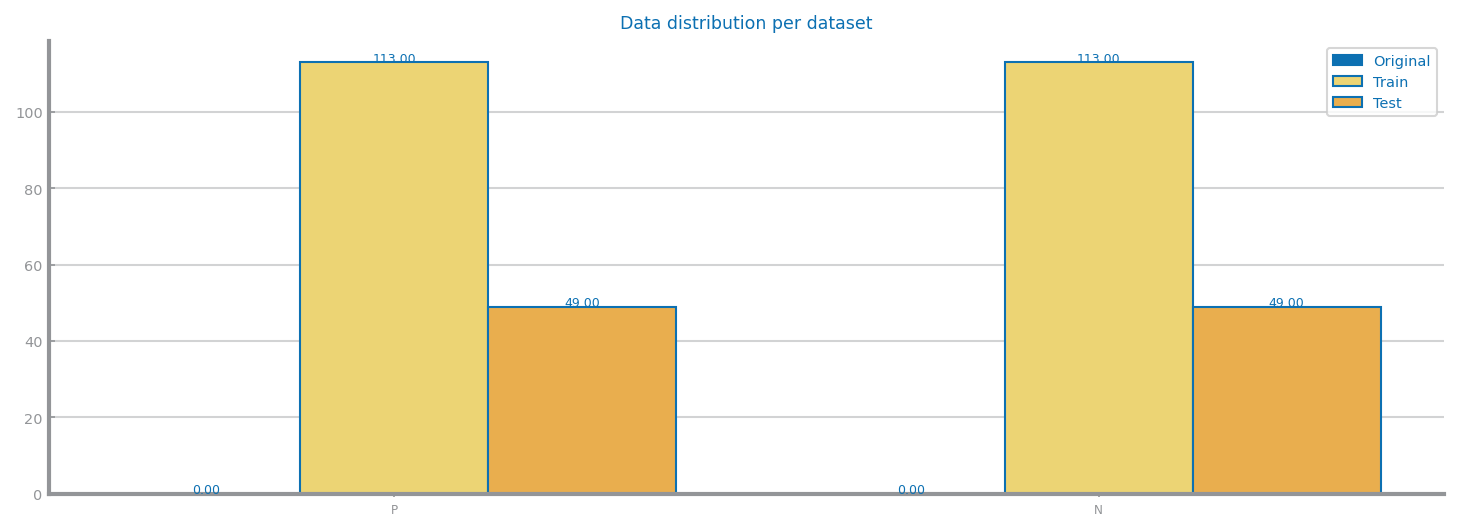

In [119]:
#Separação Teste/Treino
positive = 'P'
negative = 'N'
dataD: pd.DataFrame = pd.read_csv(file)
values = {'Original': [len(dataD[dataD[tc] == positive]), len(dataD[dataD[tc] == negative])]}

y: np.ndarray = dataD.pop(tc).values
X: np.ndarray = dataD.values
labels: np.ndarray = pd.unique(y)
labels.sort()
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = pd.concat([pd.DataFrame(trnX, columns=data.columns), pd.DataFrame(trnY,columns=[tc])], axis=1)
train.to_csv(f'{name}_train.csv', index=False)

test = pd.concat([pd.DataFrame(tstX, columns=data.columns), pd.DataFrame(tstY,columns=[tc])], axis=1)
test.to_csv(f'{name}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

<Figure size 600x450 with 0 Axes>

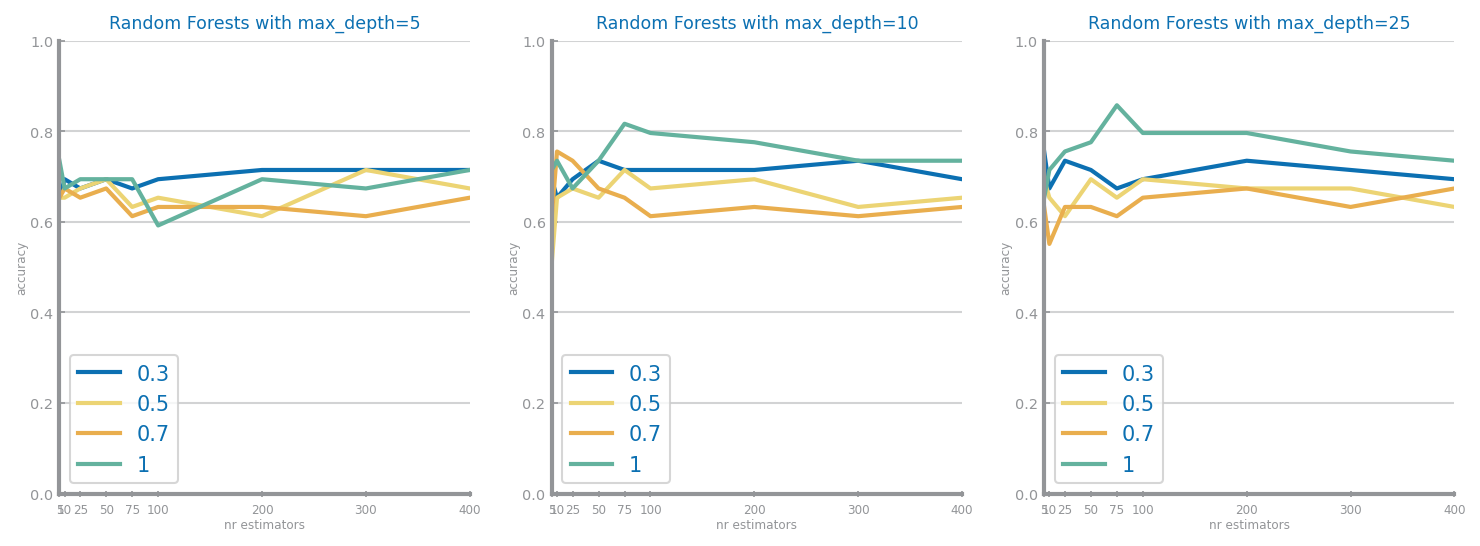

Best results with depth=25, 1.00 features and 75 estimators, with accuracy=0.86


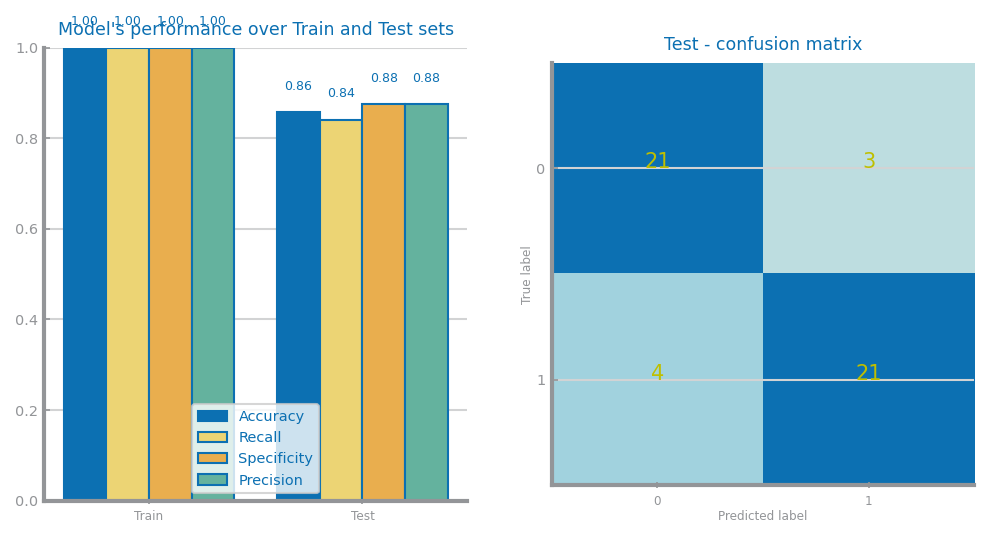

1. feature Prostate.volume (0.1353365566593597)
2. feature Age.at.MRI (0.1330280864821462)
3. feature PSA.value.at.MRI (0.1302589841143674)
4. feature Capsular.contact.lenght_TLC (0.12671952874556353)
5. feature Index.lesion.size (0.12525561938269766)
6. feature Smooth.capsular.bulging (0.05160839052123922)
7. feature regra (0.040661746715475025)
8. feature Irregular.contour (0.037593788911782236)
9. feature Gleason.score (0.034915022093519446)
10. feature Capsular.disruption (0.03250139216442448)
11. feature Black.estrition.periprostatic.fat (0.026842189360319787)
12. feature Unsharp.margin (0.02419596765594518)
13. feature Index.lesion.PIRADS.V2_4 (0.023885086641850087)
14. feature ECE.in.prostatectomy.specimen_gold.standard (0.021888568017334062)
15. feature Index.lesion.PIRADS.V2_5 (0.018863567073225954)
16. feature Measurable.ECE (0.013739348160572824)
17. feature Retoprostatic.angle.obliteration (0.01300524796635961)
18. feature Index.lesion.PIRADS.V2_3 (0.009700909333817545)


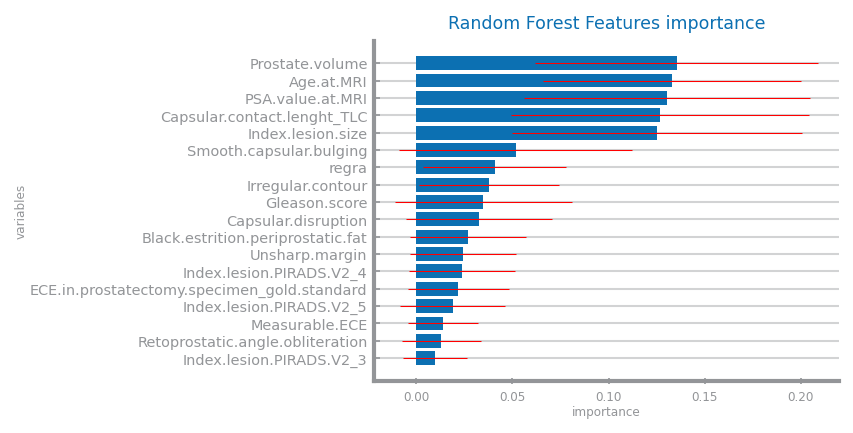

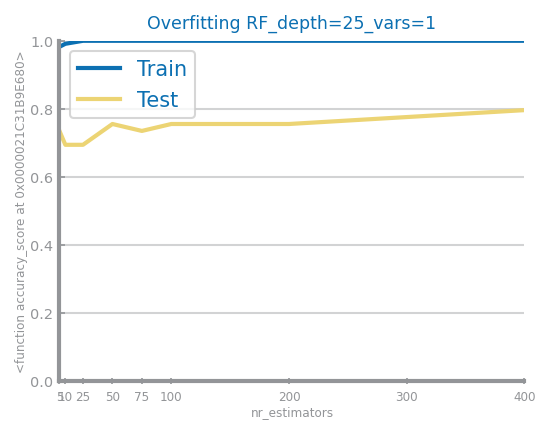

In [4]:
#Random Forests
train: pd.DataFrame = pd.read_csv(f'{name}_train.csv')
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(f'{name}_test.csv')
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
max_features = [.3, .5, .7, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
#plt.savefig(f'images/{name}_rf_study.png')
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

save_model = pickle.dumps(best_model)

#Confusion Matrix
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#plt.savefig(f'images/{name}_rf_best.png')
plt.show()

#Feature Importance 
variables = train.columns
importances = best_model.feature_importances_
stdevs = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
elems = []
for f in range(len(variables)):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, importances[indices], stdevs[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
#plt.savefig(f'images/{name}_rf_ranking.png')

#Overfitting Check
f = best[1]
max_depth = best[0]
eval_metric = accuracy_score
y_tst_values = []
y_trn_values = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
    rf.fit(trnX, trnY)
    prd_tst_Y = rf.predict(tstX)
    prd_trn_Y = rf.predict(trnX)
    y_tst_values.append(eval_metric(tstY, prd_tst_Y))
    y_trn_values.append(eval_metric(trnY, prd_trn_Y))
ds.plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'RF_depth={max_depth}_vars={f}', xlabel='nr_estimators', ylabel=str(eval_metric))

In [6]:
#Conversor
def dumm(X):
    L=np.zeros((19,), dtype=int).tolist()
    PV2=X[3]
    
    X.pop(3)
    for i in range(15):#Posição 0 à 14.
        L[i]=X[i]

    x=[3,4,5] #Valores de Index.lesion.PIRADS.V2
    if PV2==x[2]:
        L[17]=1
    if PV2==x[1]:
        L[16]=1
    if PV2==x[0]:
        L[15]=1
   
    L[-1]=X[-1]
    return L

def minmax(X,data):
    for i in range(5):
        min = data.min(axis=0)[i]
        max = data.max(axis=0)[i]
        if X[i] < min:
            min=X[i]
        if X[i] > max:
            max=X[i]
        std = (X[i] - min) / (max - min)
        #X_scaled = std * (max - min) + min
        X[i] = std
    return X

def vectorizer(X):
    for i in range(len(X)):
        X[i]=[X[i]]
    return X

In [7]:
#Previsão
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.PIRADS.V2,Index.lesion.size,
# Capsular.contact.lenght_TLC,Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,
# Irregular.contour,Black.estrition.periprostatic.fat,Retoprostatic.angle.obliteration,
# Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score,regra,surgycal margin] L=17
##-----------------------------------------------------------------------------------------------##
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.size,Capsular.contact.lenght_TLC,
# Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,Irregular.contour,Black.estrition.periprostatic.fat,
# Retoprostatic.angle.obliteration,Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score
# regra,Index.lesion.PIRADS.V2_3,Index.lesion.PIRADS.V2_4,Index.lesion.PIRADS.V2_5,surgycal margin] L=19

rfb = pickle.loads(save_model)

#Conversão -> Transformação valor na posição [3] para 
col = ['Age.at.MRI','Prostate.volume','PSA.value.at.MRI','Index.lesion.size',
       'Capsular.contact.lenght_TLC','Smooth.capsular.bulging','Capsular.disruption','Unsharp.margin',
       'Irregular.contour','Black.estrition.periprostatic.fat','Retoprostatic.angle.obliteration',
       'Measurable.ECE','ECE.in.prostatectomy.specimen_gold.standard','Gleason.score','regra',
       'Index.lesion.PIRADS.V2_3','Index.lesion.PIRADS.V2_4','Index.lesion.PIRADS.V2_5','surgycal margin']
X = [0.444078947,0.2,0.352631579,0.37037037,0.05,0,0,0,0,0,0,0,0,0,1,0,0,1,0]
XX = dumm(X)
XXX = minmax(XX,data)
XXX.pop(-1)
Y = [XXX]

pred = rfb.predict(Y)
print("Input=%s, Predicted=%s" % (Y, pred))

Input=[[0.444078947, 0.2, 0.352631579, 0.05, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], Predicted=[0]


In [8]:
#Lime
col = ['Age.at.MRI','Prostate.volume','PSA.value.at.MRI','Index.lesion.size',
       'Capsular.contact.lenght_TLC','Smooth.capsular.bulging','Capsular.disruption','Unsharp.margin',
       'Irregular.contour','Black.estrition.periprostatic.fat','Retoprostatic.angle.obliteration',
       'Measurable.ECE','ECE.in.prostatectomy.specimen_gold.standard','Gleason.score','regra',
       'Index.lesion.PIRADS.V2_3','Index.lesion.PIRADS.V2_4','Index.lesion.PIRADS.V2_5','surgycal margin']

explainer = lime.lime_tabular.LimeTabularExplainer(trnX ,class_names=['SurgycalMargin-0','SurgycalMargin-1'], feature_names = col,
                                                   categorical_features=[5,6,7,8,9,10,11,12,13,14,15,16,17], 
                                                   categorical_names=[col[i] for i in range(5,18)], kernel_width=3, verbose=True)

exp = explainer.explain_instance(np.asarray(XXX),  rfb.predict_proba, num_features=5,num_samples=1000)
exp.show_in_notebook()
exp.as_list()

Intercept 0.5379343846946031
Prediction_local [0.42]
Right: 0.28


[('Smooth.capsular.bulging=0', -0.0872106096762452),
 ('Black.estrition.periprostatic.fat=0', -0.08631606488196965),
 ('regra=0', 0.053756427632055626),
 ('PSA.value.at.MRI > 0.33', 0.04890492698154302),
 ('Irregular.contour=0', -0.044502593784750924)]